# Classification and Regression, from linear and logistic regression to neural networks


## Part a) Write own Stochastic Gradient Descent Code: First step


In [66]:
from enum import Enum
from random import random, seed
import numpy as np

def MSE(expected_values, predicted_values):
    n = np.size(predicted_values)  # Number of data points
    return np.sum((expected_values - predicted_values)**2)/n

class LinearRegressionModel(Enum):
    OrdinaryLeastSquares = 0,
    Ridge = 1

class ScalingAlgorithm(Enum):
    GradientDescent = 0,
    MomentumGD = 1, #TODO: This is probably not relevant here anymore
    StochasticGD = 2,
    Adagrad = 3,
    RMSprop = 4,
    Adam = 5

class OLS_Hessian:
    def __init__(self, n, X):
        self.H = (2.0/n)* X.T @ X
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class Ridge_Hessian:
    def __init__(self, n, lmbda, XT_X):
        self.H = (2.0/n)* XT_X+2*lmbda* np.eye(XT_X.shape[0])
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class LinearRegression:
    def __init__(self, x, y):
        # Design matrix including the intercept
        # No scaling of data and all data used for training 
        n = x.shape[0]
        self.design_matrix = np.c_[np.ones((n, 1)), x, x*x]

        self.x = x
        self.y = y

        self.ols_hessian = None
        self.ridge_hessian = None
    
    def _grad(self, eta, gradient):
        return eta*gradient

    def _momentum_grad(self, eta, gradient, momentum, change):
        return eta*gradient + momentum*change

    def _adagrad(self, gradients, eta, G_iter):
        delta  = 1e-8 # AdaGrad parameter to avoid possible division by zero

        G_iter += gradients*gradients
        update = gradients*eta/(delta+np.sqrt(G_iter))

        return [update, G_iter]
    
    def gradient_descent_OLS(self, n, n_iterations, eta, scaling_algorithm = ScalingAlgorithm.GradientDescent, rho = None, momentum = None):
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ols_hessian:
            self.ols_hessian = OLS_Hessian(n, self.design_matrix)
        
        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ols_hessian.EigValues)
        change, G_iter = 0.0, np.zeros_like(beta)
        delta  = 1e-8

        for iter in range(n_iterations):
            gradient = (2.0/n)*self.design_matrix.T @ (self.design_matrix @ beta-self.y)
            match scaling_algorithm:
                case ScalingAlgorithm.GradientDescent:
                    beta -= self._grad(eta, gradient)

                case ScalingAlgorithm.MomentumGD:
                    new_change = self._momentum_grad(eta, gradient, momentum, change)
                    change = new_change
                    beta -= new_change

                case ScalingAlgorithm.Adagrad:
                    update, new_G_iter = self._adagrad(gradient, eta, G_iter)
                    G_iter = new_G_iter
                    if momentum:
                        update = momentum*change + update
                        change = update
                    beta -= update

                case ScalingAlgorithm.RMSprop:
                    if rho is None:
                        raise ValueError("Decay rate cannot be null when scaling with RMSprop")
                    
                    G_iter = rho*G_iter + (1-rho) * gradient**2
                    update = gradient*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update
                
                case _:
                    raise NotImplementedError()
                
            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    #Function contents taken from lecture notes
    def gradient_descent_ridge(self, n, n_iterations, eta, lmbda, momentum = None): 
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ridge_hessian:
            XT_X = self.design_matrix.T @ self.design_matrix
            self.ridge_hessian = Ridge_Hessian(n, lmbda, XT_X)
        
        #Id = n*lmbda* np.eye((XT_X).shape[0])

        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ridge_hessian.EigValues)
        change = 0.0
        for iter in range(n_iterations):
            gradient = 2.0/n*self.design_matrix.T @ (self.design_matrix @ beta-self.y)+2*lmbda*beta
            #Gradient descent with momentum:
            if momentum:
                new_change = eta*gradient + momentum*change
                change = new_change
                beta -= new_change

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))
            #Gradient descent without momentum:
            else:
                beta -= eta*gradient

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    def _learning_schedule(self, t):
        t0, t1 = 5, 50
        return t0/(t+t1)
    
    def _SGD(self, beta, lin_reg_model, epoch, M, m, scaling_algorithm = ScalingAlgorithm.StochasticGD, lmbda = None, rho = None, beta_values=None, momentum = None):
        G_iter = np.zeros_like(beta)
        change = np.zeros_like(beta) if momentum else None
        delta = 1e-8 #Constant for AdaGrad
        first_moment = np.zeros_like(beta)  # Initialize for Adam first moment
        second_moment = np.zeros_like(beta)  # Initialize for Adam second moment

        for iter in range(m):
            random_index = M*np.random.randint(m)
            xi = self.design_matrix[random_index:random_index+M]
            yi = self.y[random_index:random_index+M]

            y_tilde = xi @ beta
            gradients = (2.0/M)* xi.T @ (y_tilde-yi)

            match lin_reg_model:
                case LinearRegressionModel.Ridge:
                    if not lmbda:
                        raise ValueError("Lambda cannot be null for Ridge regression")
                    gradients += 2*lmbda*beta
            
            t = epoch*m+iter
            eta = self._learning_schedule(t)
            
            match scaling_algorithm:
                case ScalingAlgorithm.StochasticGD:
                    if momentum:
                        change = momentum*change - eta*gradients
                        beta += change
                    else:
                        beta -= eta*gradients

                case ScalingAlgorithm.Adagrad:
                    G_iter += gradients * gradients
                    update = gradients*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update

                case ScalingAlgorithm.RMSprop:
                    if rho is None:
                        raise ValueError("Decay rate cannot be null when scaling with RMSprop")
                    G_iter = rho*G_iter + (1-rho) * gradients**2
                    update = gradients*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update
                
                case ScalingAlgorithm.Adam:
                    if beta_values is None:
                        raise ValueError("Beta values must be provided to run with ADAM")
                    
                    #From ChatGPT:
                    t += 1  # Increment time step
                    first_moment = beta_values[0] * first_moment + (1 - beta_values[0]) * gradients  # Update first moment
                    second_moment = beta_values[1] * second_moment + (1 - beta_values[1]) * gradients**2  # Update second moment

                    # Bias correction
                    first_term = first_moment / (1 - beta_values[0]**t)  # Corrected first moment
                    second_term = second_moment / (1 - beta_values[1]**t)  # Corrected second moment

                    update = eta * first_term / (np.sqrt(second_term) + delta)  # Update parameters

                    beta -= update
                    
                case _:
                    raise NotImplementedError()

        return beta

    
    def SGD_OLS(self, n_datapoints, batch_size, n_epochs, scaling_algorithm = ScalingAlgorithm.StochasticGD, rho = None, beta_values = None, momentum = None):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.OrdinaryLeastSquares, epoch, batch_size, m, scaling_algorithm, rho=rho, beta_values=beta_values, momentum=momentum)
            
            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))
        
        return [betas, scores]
    
    def SGD_Ridge(self, n_datapoints, batch_size, n_epochs, lmbda, scaling_algorithm = ScalingAlgorithm.StochasticGD):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.Ridge, epoch, batch_size, m, scaling_algorithm, lmbda)

            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]    

In [67]:
def Get_best_mse_and_eta(mse_data, learning_rates):
    min_mse = np.min(mse_data)
    best_index = np.argmin(mse_data)
    best_learning_rate = learning_rates[best_index]

    return [min_mse, best_learning_rate]

In [68]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Set-up taken from lecture notes
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+5*x*x + np.random.randn(n, 1)

N_iterations = 30

linear_regression = LinearRegression(x, y)

Best learning rate for OLS: 0.05 with MSE: 0.9497802399051559
Best learning rate for Ridge: 0.1 with MSE: 0.9592591797135442


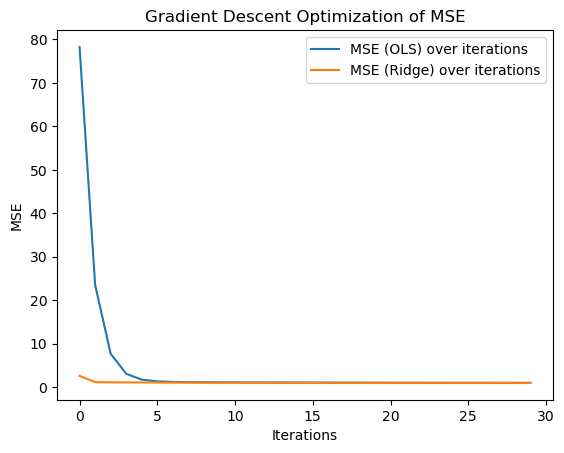

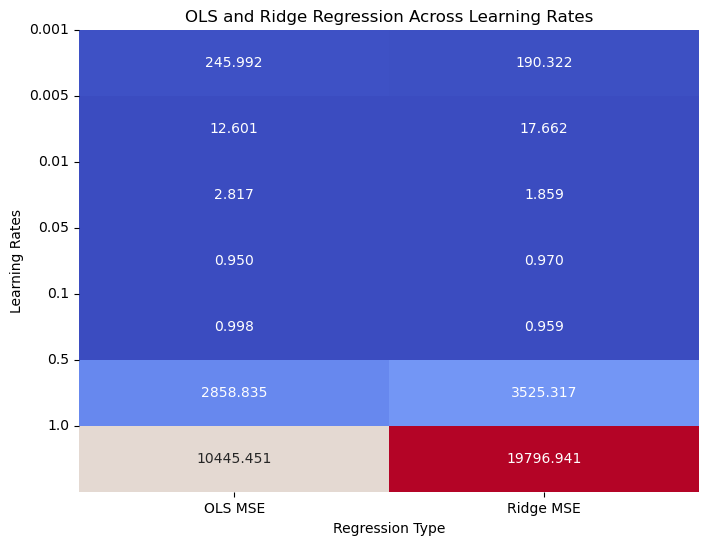

In [69]:
#Gradient descent
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
mse_data_test = list()
for i, eta in enumerate(learning_rates):
    ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, eta)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, eta, lmbda=0.01)
    mse_data[i, 1] = min(ridge_mses)

    # print(f"OLS - eta: {eta}, mse: {ols_mse}")
    # print(f"Ridge - eta: {eta}, mse: {ridge_mse}")


# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I'm lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, ols_best_eta)
ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, ridge_best_eta, lmbda=0.01)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE")
plt.legend()
plt.show()


# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




Best learning rate for OLS: 0.05 with MSE: 0.9530114389231551
Best learning rate for Ridge: 0.1 with MSE: 0.9547791193538318


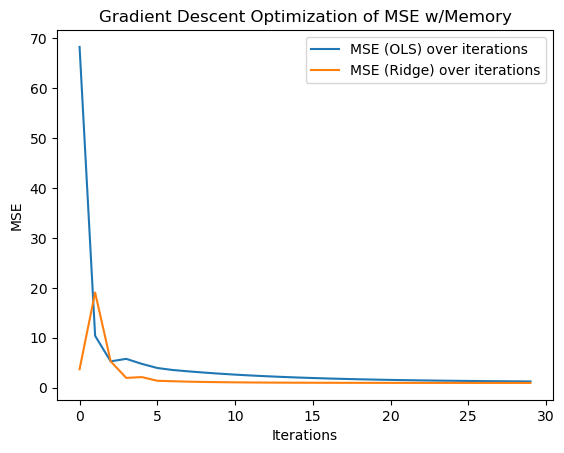

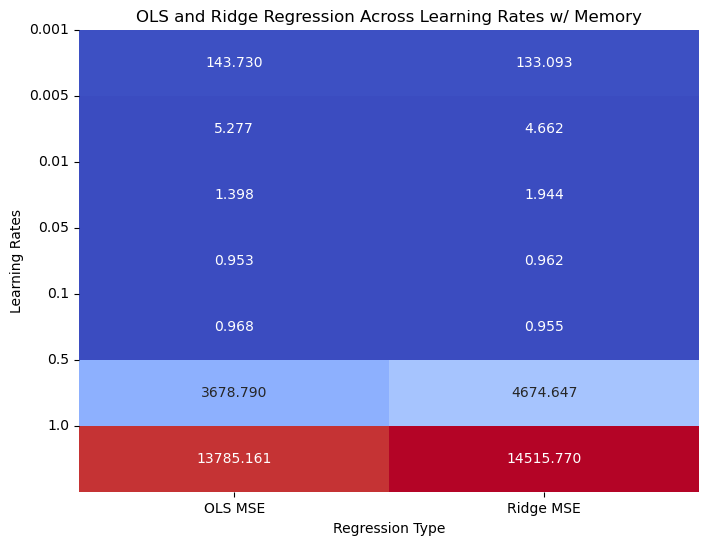

In [70]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Gradient descent with momentum
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
momentum = 0.3
for i, eta in enumerate(learning_rates):
    #OLS
    ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, eta, ScalingAlgorithm.MomentumGD, momentum=momentum)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, eta, 0.01, momentum=momentum)
    mse_data[i, 1] = min(ridge_mses)

    #print(f"OLS - eta: {eta}, mse: {ols_mse}    Ridge - eta: {eta}, mse: {ridge_mse}")

# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I am lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, ols_best_eta, ScalingAlgorithm.MomentumGD, momentum=momentum)
ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, ridge_best_eta, 0.01, momentum=momentum)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE w/Memory")
plt.legend()
plt.show()

# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates w/ Memory")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




Best settings for OLS: Mini-batch size = 5, Epochs = 100 with MSE: 0.9493805713189313
Best settings for Ridge: Mini-batch size = 5, Epochs = 1000 with MSE: 0.9493695661396717


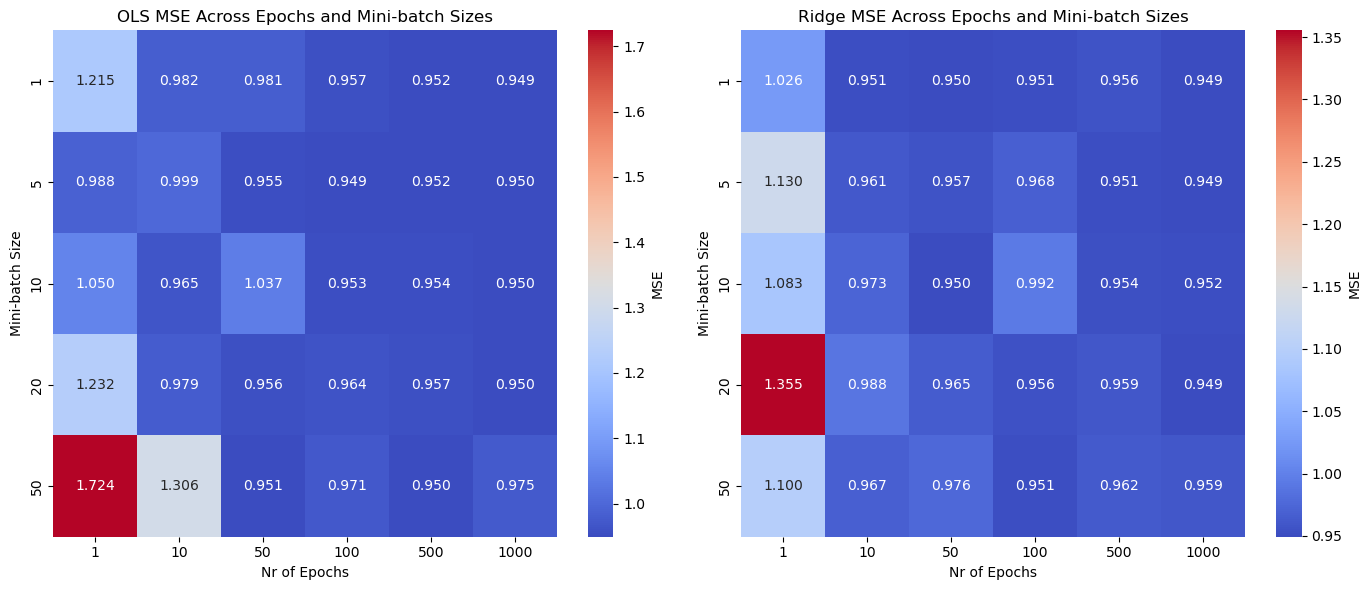

In [71]:
#SGD with batches and epocs

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Test for different nr epochs
epochs = np.array([1, 10, 50, 100, 500, 1000])
#.. and batch size
batch_sizes = np.array([1, 5, 10, 20, 50])
mse_data_ols = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
mse_data_ridge = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
for j, M in enumerate(batch_sizes):
    for i, n_epochs in enumerate(epochs):
        beta_ols, scores_ols = linear_regression.SGD_OLS(n, M, n_epochs)
        mse_data_ols[j, i] = min(scores_ols)

        beta_ridge, scores_ridge = linear_regression.SGD_Ridge(n, M, n_epochs, lmbda=0.01)
        mse_data_ridge[j, i] = min(scores_ridge)

# Find the minimum MSE and corresponding indices for OLS
ols_min_mse_index = np.unravel_index(np.argmin(mse_data_ols, axis=None), mse_data_ols.shape)
ols_min_mse = mse_data_ols[ols_min_mse_index]
ols_best_mini_batch_size = batch_sizes[ols_min_mse_index[0]]
ols_best_n_epochs = epochs[ols_min_mse_index[1]]

# Find the minimum MSE and corresponding indices for Ridge
ridge_min_mse_index = np.unravel_index(np.argmin(mse_data_ridge, axis=None), mse_data_ridge.shape)
ridge_min_mse = mse_data_ridge[ridge_min_mse_index]
ridge_best_mini_batch_size = batch_sizes[ridge_min_mse_index[0]]
ridge_best_n_epochs = epochs[ridge_min_mse_index[1]]

# Print results
print(f"Best settings for OLS: Mini-batch size = {ols_best_mini_batch_size}, Epochs = {ols_best_n_epochs} with MSE: {ols_min_mse}")
print(f"Best settings for Ridge: Mini-batch size = {ridge_best_mini_batch_size}, Epochs = {ridge_best_n_epochs} with MSE: {ridge_min_mse}")

# Create a DataFrame for heatmap plotting
mse_df_ols = pd.DataFrame(mse_data_ols, index=batch_sizes, columns=epochs)
mse_df_ridge = pd.DataFrame(mse_data_ridge, index=batch_sizes, columns=epochs)


# Plot the heatmap
plt.figure(figsize=(14, 6))

# OLS MSE Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(mse_df_ols, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("OLS MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

# Ridge MSE Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(mse_df_ridge, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Ridge MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

plt.tight_layout()
plt.show()


In [72]:
#Adagrad
n = 100
n_iterations = 1000
eta = 0.1
momentum = 0.3
batch_size = 5
epochs = 100

#Regular adagrad
ada_betas, ada_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.Adagrad)
print(f"Best GD AdaGrad: {min(ada_mses)}")

#Adagrad with momentum
ada_betas, ada_mses_with_momentum = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.Adagrad, momentum)
print(f"Best GD AdaGrad with momentum: {min(ada_mses_with_momentum)}")

#SGD with AdaGrad
ada_betas, sgd_ada_mses = linear_regression.SGD_OLS(n, batch_size, epochs, ScalingAlgorithm.Adagrad)
print(f"Best SGD AdaGrad: {min(sgd_ada_mses)}")

#SGD with AdaGrad and momentum
ada_betas, sgd_ada_mses_with_momentum = linear_regression.SGD_OLS(n, batch_size, epochs, ScalingAlgorithm.Adagrad, momentum=momentum)
print(f"Best SGD AdaGrad with momentum: {min(sgd_ada_mses_with_momentum)}")

#For comparison
#GD:
gd_betas, gd_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.GradientDescent)
print(f"Best GD: {min(gd_mses)}")

#GD with momentum:
gd_betas, gd_mses_with_momentum = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.GradientDescent, momentum=momentum)
print(f"Best GD with momentum: {min(gd_mses_with_momentum)}")

#SGD:
sgd_betas, sgd_mses = linear_regression.SGD_OLS(n, batch_size, epochs)
print(f"Best SGD: {min(sgd_mses)}")

#SGD with momentum:
sgd_betas, sgd_mses_with_momentum = linear_regression.SGD_OLS(n, batch_size, epochs, momentum=momentum)
print(f"Best SGD with momentum: {min(sgd_mses_with_momentum)}")

Best GD AdaGrad: 1.4001568753034894
Best GD AdaGrad with momentum: 1.0024056787500215
Best SGD AdaGrad: 1.2164453109018138
Best SGD AdaGrad with momentum: 0.997401025612732
Best GD: 0.9493683153785549
Best GD with momentum: 0.9493702546768614
Best SGD: 0.9511768617995251
Best SGD with momentum: 0.95067398653956


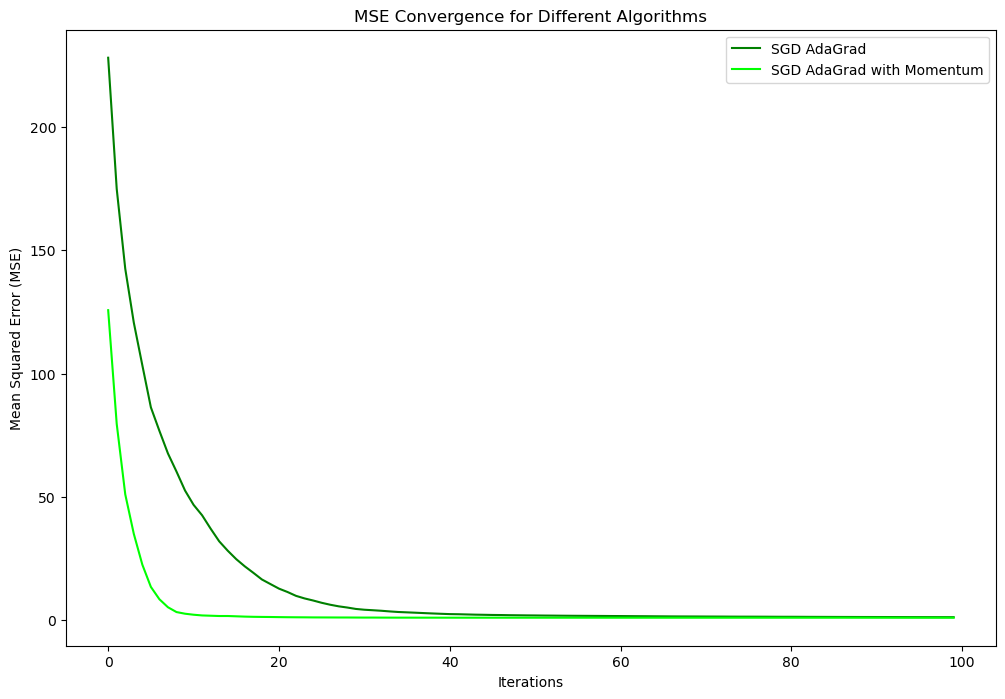

In [73]:
import matplotlib.pyplot as plt

# Set up a figure
plt.figure(figsize=(12, 8))

# Plot MSEs for each algorithm configuration
#plt.plot(range(len(ada_mses)), ada_mses, label="GD AdaGrad", color="blue")
#plt.plot(range(len(ada_mses_with_momentum)), ada_mses_with_momentum, label="GD AdaGrad with Momentum", color="cyan")
plt.plot(range(len(sgd_ada_mses)), sgd_ada_mses, label="SGD AdaGrad", color="green")
plt.plot(range(len(sgd_ada_mses_with_momentum)), sgd_ada_mses_with_momentum, label="SGD AdaGrad with Momentum", color="lime")
#plt.plot(range(len(gd_mses)), gd_mses, label="GD", color="red")
#plt.plot(range(len(gd_mses_with_momentum)), gd_mses_with_momentum, label="GD with Momentum", color="orange")
#plt.plot(range(len(sgd_mses)), sgd_mses, label="SGD", color="purple")
#plt.plot(range(len(sgd_mses_with_momentum)), sgd_mses_with_momentum, label="SGD with Momentum", color="magenta")

# Add labels and title
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Convergence for Different Algorithms")
plt.legend()

# Show the plot
plt.show()


In [74]:
#RMSprop
betas, rms_prop_mses = linear_regression.gradient_descent_OLS(n=100, n_iterations=100, eta=0.1, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9)
print(f"Best GD RMSprop: {min(rms_prop_mses)}")

#RMSprop with momentum
betas, rms_prop_mses_momentum = linear_regression.gradient_descent_OLS(n=100, n_iterations=100, eta=0.1, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9, momentum=0.9)
print(f"Best GD RMSprop with momentum: {min(rms_prop_mses_momentum)}")

#SGD with RMSprop
betas, sgd_rms_prop_mses = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9)
print(f"Best SGD RMSprop: {min(sgd_rms_prop_mses)}")

#SGD with RMSprop with momentum
betas, sgd_rms_prop_mses_momentum = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9, momentum=0.9)
print(f"Best SGD RMSprop with momentum: {min(sgd_rms_prop_mses_momentum)}")

#SGD with ADAM
betas, sgd_rms_prop_mses_adam = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.Adam, beta_values=[0.9, 0.999], momentum=0.2)
print(f"Best SGD ADAM: {min(sgd_rms_prop_mses_adam)}")

#SGD with ADAM
betas, sgd_rms_prop_mses_adam_momentum = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.Adam, beta_values=[0.9, 0.999], momentum=0.2)
print(f"Best SGD ADAM with momentum: {min(sgd_rms_prop_mses_adam_momentum)}")


Best GD RMSprop: 0.9880199324961001
Best GD RMSprop with momentum: 0.9498441506660921
Best SGD RMSprop: 0.9495530680156243
Best SGD RMSprop with momentum: 0.9506939850251832
Best SGD ADAM: 0.9495104587273024
Best SGD ADAM with momentum: 0.9495623070539584


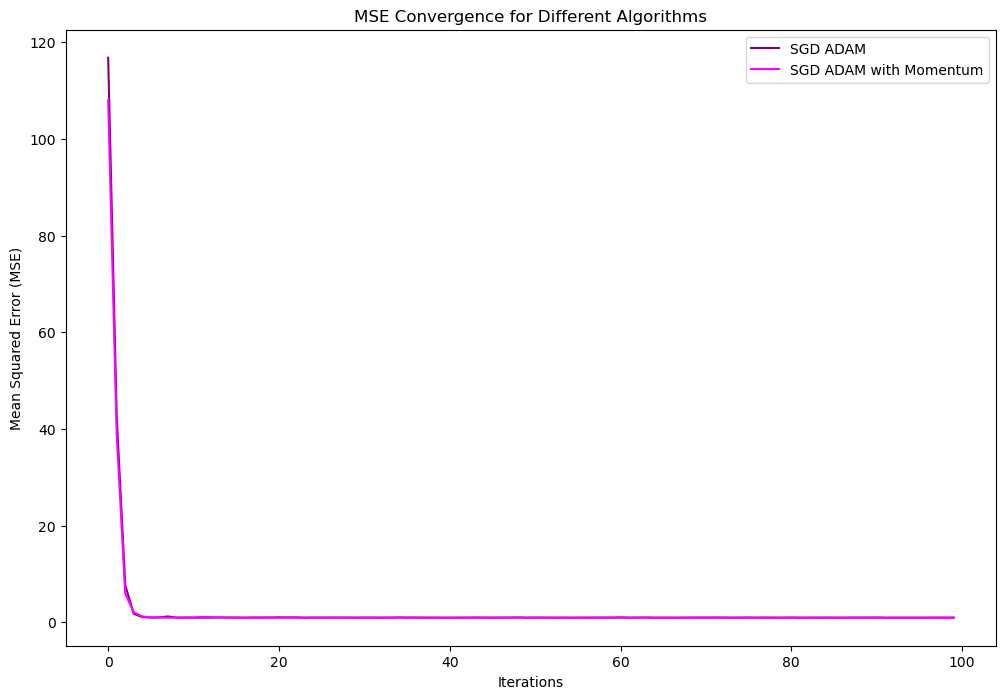

In [75]:
import matplotlib.pyplot as plt

# Assuming `rms_prop_mses`, `rms_prop_mses_momentum`, etc. contain MSE values for each configuration

# Set up a figure
plt.figure(figsize=(12, 8))

# Plot MSEs for each configuration
#plt.plot(range(len(rms_prop_mses)), rms_prop_mses, label="GD RMSprop", color="blue")
#plt.plot(range(len(rms_prop_mses_momentum)), rms_prop_mses_momentum, label="GD RMSprop with Momentum", color="cyan")
#plt.plot(range(len(sgd_rms_prop_mses)), sgd_rms_prop_mses, label="SGD RMSprop", color="green")
#plt.plot(range(len(sgd_rms_prop_mses_momentum)), sgd_rms_prop_mses_momentum, label="SGD RMSprop with Momentum", color="lime")
plt.plot(range(len(sgd_rms_prop_mses_adam)), sgd_rms_prop_mses_adam, label="SGD ADAM", color="purple")
plt.plot(range(len(sgd_rms_prop_mses_adam_momentum)), sgd_rms_prop_mses_adam_momentum, label="SGD ADAM with Momentum", color="magenta")

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Convergence for Different Algorithms")
plt.legend()

# Show the plot
plt.show()


## Part b) Writing your own neural network code (Central part of the project)



In [76]:
import numpy as np
import NeuralNetwork as nn
# We use the Sigmoid function as activation function

# ensure the same random numbers appear every time
np.random.seed(0)
# Input variable
x = np.array([4.0],dtype=np.float64)
# Target values
y = 2*x+1.0 
y += np.random.normal(0, 100, y.shape)

# Defining the neural network, only scalars here
n_inputs = x.shape
n_features = 1
n_hidden_neurons = 1
n_outputs = 1

n_iterations = 50
#TODO: Some stopping condition

#Set up and train simple model
model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, random_state=3)
epochs, loss = model.train(n_iterations, learning_rate=0.1)

print(f"Epoch {epochs}, Loss: {loss}")


Epoch 50, Loss: 8.277449677184886e-06


In [77]:
#Compare to scikit learn
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

import NeuralNetwork as nn

# 1. Generate synthetic data for regression
# Ensure the same random numbers appear every time
np.random.seed(0)

X, y = make_regression(n_samples=100, n_features=1, noise=10)

# 2. Initialize and fit the Scikit-learn MLPRegressor
scikit_model = MLPRegressor(hidden_layer_sizes=(1,),
                             activation='logistic',
                             learning_rate_init=0.001,
                             max_iter=100,
                             random_state=0)

scikit_model.fit(X, y)

# 3. Predictions and evaluation using Scikit-learn
y_pred_sklearn = scikit_model.predict(X)
mse_sklearn = mean_squared_error(y, y_pred_sklearn)
print(f"Mean Squared Error with Scikit-learn: {mse_sklearn}")

# 4. Initialize and train custom neural network
hidden_layers = list([nn.HiddenLayer(nn.ActivationFunction.Sigmoid, n_features=1, n_hidden_neurons=5)])
custom_model = nn.NeuralNetwork(X, y.reshape(-1, 1), nn.CostFunction.MSE, hidden_layers=hidden_layers)

epoch, loss = custom_model.train(epochs=100, learning_rate=0.001)
print(f"Mean Squared Error with custom neural net: {loss}")

#TODO: Change different params and study the results
# iterations = 300
# for iter in iterations:
    

Mean Squared Error with Scikit-learn: 1959.8704818704252
Mean Squared Error with custom neural net: 150.19706175827682


/opt/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## Part c) Testing different activation functions for the hidden layers


In [78]:
import numpy as np
import NeuralNetwork as nn

#Same set up as before
np.random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += np.random.normal(0, 100, y.shape)

eta = 0.1
#RELU verbosity test:
relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=1)
epoch, loss = relu_model.train(epochs=50, learning_rate=eta, verbosity=True)
print(f"Eta: {eta} - RELU loss after {epoch} iterations: {loss}")



Epoch 1, Loss: 30572.95723283121
Epoch 2, Loss: 3160630109.6529064
Epoch 3, Loss: 33522571.582508296
Epoch 4, Loss: 27153288.245976385
Epoch 5, Loss: 21994166.842747573
Epoch 6, Loss: 17815277.312784314
Epoch 7, Loss: 14430376.00832279
Epoch 8, Loss: 11688605.42249608
Epoch 9, Loss: 9467770.887507504
Epoch 10, Loss: 7668894.668456799
Epoch 11, Loss: 6211804.764895611
Epoch 12, Loss: 5031561.832699292
Epoch 13, Loss: 4075564.9866672913
Epoch 14, Loss: 3301207.4981824206
Epoch 15, Loss: 2673977.908784043
Epoch 16, Loss: 2165921.931165464
Epoch 17, Loss: 1754396.5883114836
Epoch 18, Loss: 1421061.0657373415
Epoch 19, Loss: 1151059.3014766108
Epoch 20, Loss: 932357.8837382973
Epoch 21, Loss: 755209.747840115
Epoch 22, Loss: 611719.7706007017
Epoch 23, Loss: 495492.90170605783
Epoch 24, Loss: 401349.150048693
Epoch 25, Loss: 325092.7226120028
Epoch 26, Loss: 263325.0269291219
Epoch 27, Loss: 213293.2030466787
Epoch 28, Loss: 172767.4343946943
Epoch 29, Loss: 139941.56957585012
Epoch 30, Los

Eta: 0.1 - Sigmoid loss after 50 iterations: 8.2803472633238e-06
Eta: 0.1 - RELU loss after 50 iterations: 2217.1161724530407
Eta: 0.1 - Leaky RELU loss after 50 iterations: nan

Eta: 0.01 - Sigmoid loss after 50 iterations: 4650.416269865989
Eta: 0.01 - RELU loss after 50 iterations: 14039.690938106532
Eta: 0.01 - Leaky RELU loss after 50 iterations: 2279.917183830382

Eta: 0.001 - Sigmoid loss after 50 iterations: 27688.416075363162
Eta: 0.001 - RELU loss after 50 iterations: 1.2100606260480736e-07
Eta: 0.001 - Leaky RELU loss after 50 iterations: 1.2100606260480736e-07

Eta: 0.0001 - Sigmoid loss after 50 iterations: 33034.92612724381
Eta: 0.0001 - RELU loss after 50 iterations: 0.8066688754213597
Eta: 0.0001 - Leaky RELU loss after 50 iterations: 0.8066688754213597



/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:57: RuntimeWarning: overflow encountered in square
  return np.sum((y_target - y_pred)**2)/n
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:214: RuntimeWarning: overflow encountered in matmul
  delta = np.matmul(delta_output, self.output_layer.get_weights().T) * self.hidden_layers[-1].derivative(activations[-2])
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:215: RuntimeWarning: overflow encountered in matmul
  output_weights_gradient = np.matmul(activations[-2].T, delta_output)
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:153: RuntimeWarning: invalid value encountered in divide
  layer.w -= self.alpha * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:164: RuntimeWarning: invalid value encountered in divide
  layer.b -= self.alpha * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
/Users/helle/Documents/UiO/Fys-

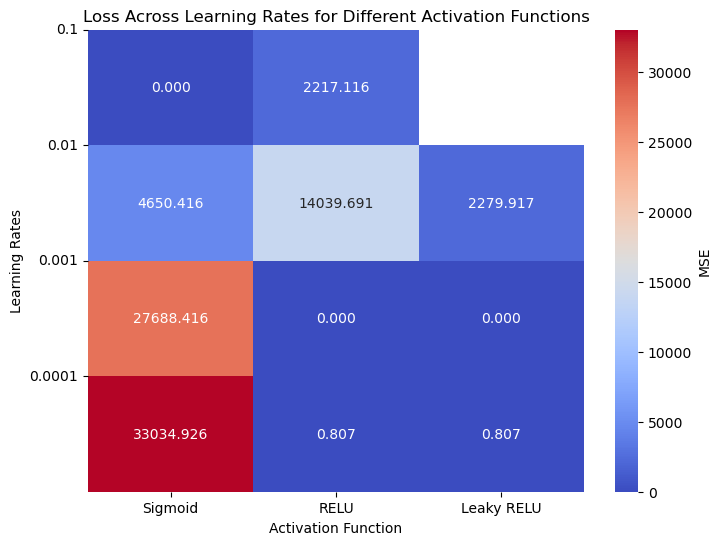

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

learning_rates = [0.1, 0.01, 0.001, 0.0001]
for eta in learning_rates:
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, random_state=0)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(epochs=50, learning_rate=eta)
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {eta} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0)
    epoch, loss_relu = relu_model.train(epochs=50, learning_rate=eta)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {eta} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0)
    epoch, loss_leaky = leaky_relu_model.train(epochs=50, learning_rate=eta)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {eta} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()

#TODO: Look at init bias and weights, and if those should be different for different activations
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Learning Rates for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=loss_df.index, rotation=0)
plt.show()



[[1.76405235]]
Eta: 0.1 - Sigmoid loss after 10 iterations: 607.3738701370002
Eta: 0.001 - RELU loss after 10 iterations: 0.012035626168635549
Eta: 0.001 - Leaky RELU loss after 10 iterations: 0.012035626168635549

[[0.09120472]]
Eta: 0.1 - Sigmoid loss after 10 iterations: 683.3384446860957
Eta: 0.001 - RELU loss after 10 iterations: 83.33189866844363
Eta: 0.001 - Leaky RELU loss after 10 iterations: 83.33189866844363

[[-0.71239066]]
Eta: 0.1 - Sigmoid loss after 10 iterations: 5158.44070761272
Eta: 0.001 - RELU loss after 10 iterations: 33758.287424248694
Eta: 0.001 - Leaky RELU loss after 10 iterations: 33757.51641440088

[[0.49671415]]
Eta: 0.1 - Sigmoid loss after 10 iterations: 634.1716984522708
Eta: 0.001 - RELU loss after 10 iterations: 2.092751459993585
Eta: 0.001 - Leaky RELU loss after 10 iterations: 2.092751459993585

[[-1.74976547]]
Eta: 0.1 - Sigmoid loss after 10 iterations: 5158.6795965005085
Eta: 0.001 - RELU loss after 10 iterations: 33758.287424248694
Eta: 0.001 - L

/var/folders/16/vv67yqq12653l08qz2zn9sd80000gn/T/ipykernel_15166/137271937.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intial_weights[i] = np.round(w, 2)


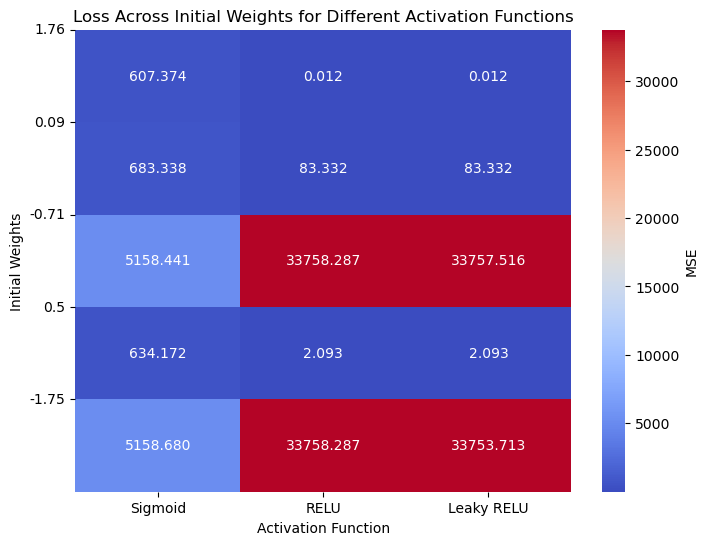

In [80]:
#Picking the best learning rates for each model, test different initial weight seeds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

weight_seeds = [0, 8, 13, 42, 100]
intial_weights = np.zeros(len(weight_seeds))
for i, seed in enumerate(weight_seeds):
    np.random.seed(seed)
    w = np.random.randn(1, 1)
    print(w)
    intial_weights[i] = np.round(w, 2)
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, random_state=seed)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(epochs=10, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {0.1} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=seed)
    epoch, loss_relu = relu_model.train(epochs=10, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {0.001} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=seed)
    epoch, loss_leaky = leaky_relu_model.train(epochs=10, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {0.001} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=intial_weights) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Initial Weights for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Initial Weights")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(intial_weights)), labels=loss_df.index, rotation=0)
plt.show()




Eta: 0.001 - RELU loss after 5 iterations: 9.472278710816722
Eta: 0.001 - Leaky RELU loss after 5 iterations: 9.472278710816722

Eta: 0.001 - RELU loss after 5 iterations: 9.260771305855128
Eta: 0.001 - Leaky RELU loss after 5 iterations: 9.260771305855128

Eta: 0.001 - RELU loss after 5 iterations: 8.845709929376515
Eta: 0.001 - Leaky RELU loss after 5 iterations: 8.845709929376515

Eta: 0.001 - RELU loss after 5 iterations: 7.4757707029894
Eta: 0.001 - Leaky RELU loss after 5 iterations: 7.4757707029894

Eta: 0.001 - RELU loss after 5 iterations: 1.9912681424254959
Eta: 0.001 - Leaky RELU loss after 5 iterations: 1.9912681424254959

Eta: 0.001 - RELU loss after 5 iterations: 0.0340628748535035
Eta: 0.001 - Leaky RELU loss after 5 iterations: 0.0340628748535035



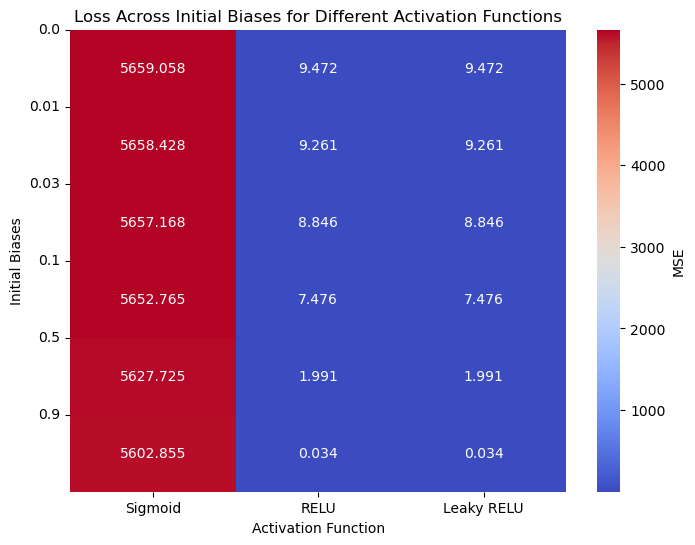

In [81]:
#Picking the best learning rates for each model, test different initial bias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

#Skipping Sigmoid here as it needs a lot more iterations in order to get to zero
loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

initial_bias = [0, 0.01, 0.03, 0.1, 0.5, 0.9]
for bias in initial_bias:
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, random_state=0, hidden_bias=bias, output_bias=bias)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(epochs=5, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    loss_data["Sigmoid"].append(loss_sigmoid)

    # print(f"Eta: {0.1} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0, hidden_bias=bias, output_bias=bias)
    epoch, loss_relu = relu_model.train(epochs=5, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {0.001} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0, hidden_bias=bias, output_bias=bias)
    epoch, loss_leaky = leaky_relu_model.train(epochs=5, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {0.001} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=initial_bias) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Initial Biases for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Initial Biases")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(initial_bias)), labels=loss_df.index, rotation=0)
plt.show()




Eta: 0.1 - Sigmoid loss after 1 iterations: 33724.64185974832
Eta: 0.001 - RELU loss after 1 iterations: 29060.04298205365
Eta: 0.001 - Leaky RELU loss after 1 iterations: 29060.04298205365

Eta: 0.1 - Sigmoid loss after 3 iterations: 13817.098488319736
Eta: 0.001 - RELU loss after 3 iterations: 6519.556929481639
Eta: 0.001 - Leaky RELU loss after 3 iterations: 6519.556929481639

Eta: 0.1 - Sigmoid loss after 8 iterations: 1483.1750998451773
Eta: 0.001 - RELU loss after 8 iterations: 1.8021187945543823e-06
Eta: 0.001 - Leaky RELU loss after 8 iterations: 1.8021187945543823e-06

Eta: 0.1 - Sigmoid loss after 10 iterations: 607.3738701370002
Eta: 0.001 - RELU loss after 10 iterations: 0.0001015211719175534
Eta: 0.001 - Leaky RELU loss after 10 iterations: 0.0001015211719175534

Eta: 0.1 - Sigmoid loss after 30 iterations: 0.07945400082036101
Eta: 0.001 - RELU loss after 30 iterations: 5.064281016507343e-06
Eta: 0.001 - Leaky RELU loss after 30 iterations: 5.064281016507343e-06

Eta: 0.1 

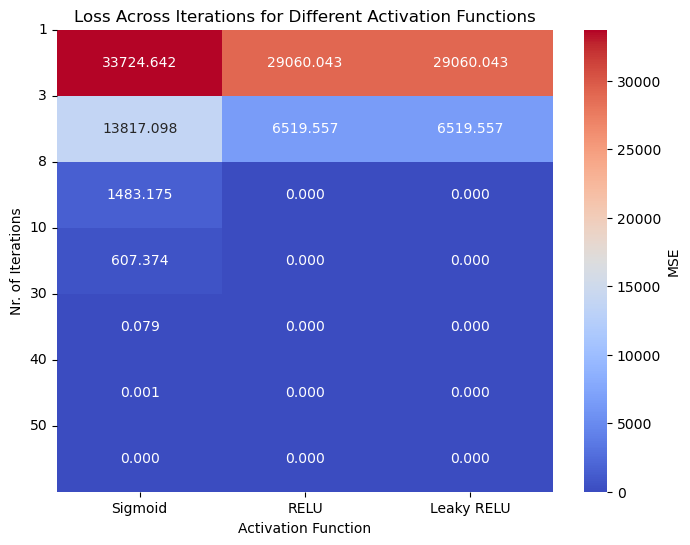

In [82]:
#Picking the best learning rates for each model, test different nr of iterations
#TODO: Should really just run it once and get an output for each iteration and plot as a graph as seen in a, but then need to store output in the model, and can't be arsed right now

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

#Skipping Sigmoid here as it needs a lot more iterations in order to get to zero
loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

n_iterations = [1, 3, 8, 10, 30, 40, 50]
for n_iter in n_iterations:
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, random_state=0)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(epochs=n_iter, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {0.1} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0, hidden_bias=0.9, output_bias=0.9)
    epoch, loss_relu = relu_model.train(epochs=n_iter, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {0.001} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(x, y, nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0, hidden_bias=0.9, output_bias=0.9)
    epoch, loss_leaky = leaky_relu_model.train(epochs=n_iter, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {0.001} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=n_iterations) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Iterations for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Nr. of Iterations")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(n_iterations)), labels=loss_df.index, rotation=0)
plt.show()




## Part d) Classification analysis using neural networks


The content of the breast cancer dataset is:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
-------------------------
inputs =  (569, 30)
outputs =  (569,)
labels =  (30,)


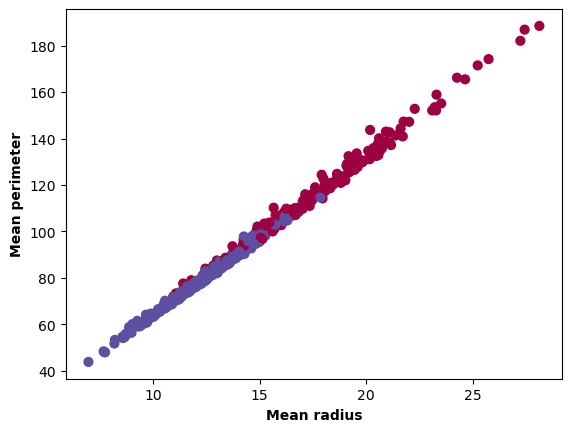

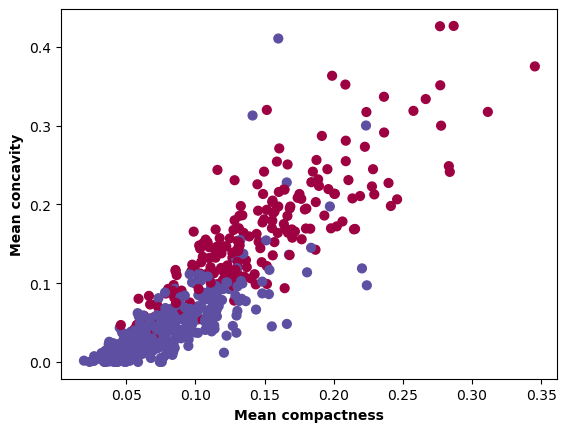

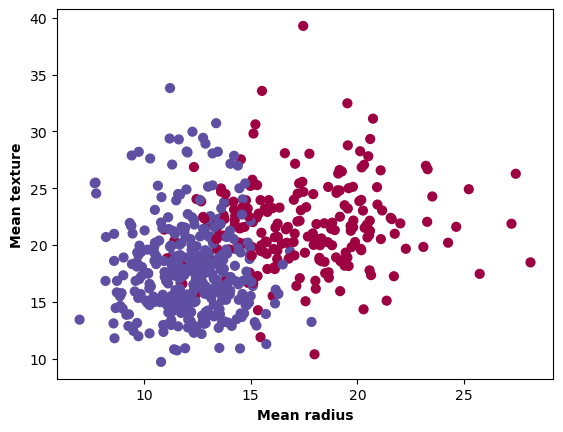

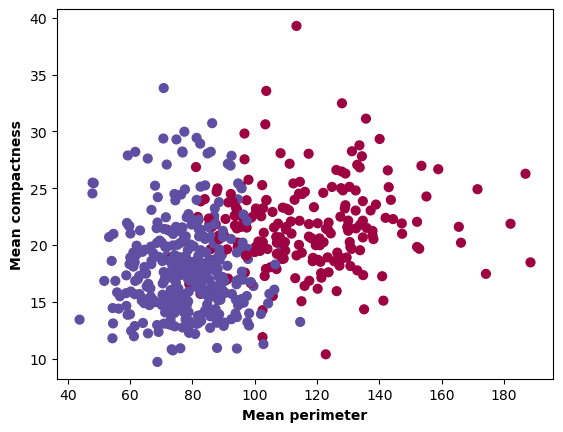

In [83]:
#From lecture notes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as splitter
from sklearn.datasets import load_breast_cancer
import pickle
import os 


"""Load breast cancer dataset"""

np.random.seed(0)        #create same seed for random number every time

cancer=load_breast_cancer()      #Download breast cancer dataset

inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

print('The content of the breast cancer dataset is:')      #Print information about the datasets
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

x=inputs      #Reassign the Feature and Label matrices to other variables
y=outputs

#%% 

# Visualisation of dataset (for correlation analysis)

plt.figure()
plt.scatter(x[:,0],x[:,2],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean perimeter',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,5],x[:,6],s=40,c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness',fontweight='bold')
plt.ylabel('Mean concavity',fontweight='bold')
plt.show()


plt.figure()
plt.scatter(x[:,0],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean texture',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,2],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter',fontweight='bold')
plt.ylabel('Mean compactness',fontweight='bold')
plt.show()

In [84]:
#Wisconsin Breast Cancer Data Set
import numpy as np
import sklearn.datasets as ds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import NeuralNetwork as nn

#Data set
data_set = ds.load_breast_cancer() 
X, target = data_set.data, data_set.target
target = target.reshape(target.shape[0], 1)
X_train, X_test, y_train, y_test = train_test_split(X, target) #test_size=0.2, random_state=0)

#Scale
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = nn.NeuralNetwork(
        X_train, 
        y_train, 
        nn.CostFunction.Cross_Entropy,
        #random_state=1030, 
        random_state=33,
        output_activation=nn.ActivationFunction.Sigmoid,
        hidden_activation=nn.ActivationFunction.RELU,
        hidden_bias=0.5,
        hidden_neurons=100,
        n_outputs=1)

#model.add_hidden_layer(nn.HiddenLayer(nn.ActivationFunction.RELU, n_features=100, n_hidden_neurons=30, hidden_bias=0.1))

#Initialise model
eta = 0.1
n_iterations = 3

# Train the model
epoch, accuracy = model.train(epochs=n_iterations, learning_rate=eta, verbosity=True)

y_pred = model.predict(X_test).squeeze()

#equivalent in numpy
def accuracy_score(Y_test, Y_pred):
    assert Y_pred.size == Y_test.size
    return np.average((target == Y_pred))

print("Accuracy score on test set: ", accuracy_score(y_test, y_pred))


Epoch 1, Loss: 7.630850950713266
Epoch 2, Loss: 7.734740065275774
Epoch 3, Loss: 7.734740065275774
Accuracy score on test set:  0.6274165202108963


## Part e) Write your logistic regression code


In [86]:
#sklearn

#Compare to scikit learn
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.datasets as ds
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Data set
data_set = ds.load_breast_cancer() 
X, target = data_set.data, data_set.target
target = target.reshape(target.shape[0], 1)
X_train, X_test, y_train, y_test = train_test_split(X, target) #test_size=0.2, random_state=0)

#Scale
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

np.random.seed(0)


sklearn_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',          
    solver='adam',             
    alpha=0.0001,               
    learning_rate_init=0.001,   
    max_iter=100,               
    random_state=0             
)

sklearn_model.fit(X_train, y_train)

y_pred = sklearn_model.predict(X_test)

# Calculate accuracy
sklearn_accuracy = accuracy_score(y_test, y_pred)

print("Sklearn MLPClassifier accuracy:", sklearn_accuracy)


/opt/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Sklearn MLPClassifier accuracy: 0.951048951048951


/opt/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [87]:
#Logistic regression code
#TODO